## Stationary Navier-Stokes with Picard Linearization

In [1]:
using Revise
using CairoMakie
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra

In [2]:
@variables ϵ r x₁ x₂ t Δt;
const nu = 1.0
μ = 0.0025
ρ = 1.0
#ϕ = 1//945 * ((ϵ*r)^5 +15*(ϵ*r)^3 + 105*(ϵ*r)^2 + 945*(ϵ*r)+ 945)* exp(-ϵ*r)
ϕ = exp(-r^2*ϵ^2)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
#display(ϕ)  
Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
∂₁(exprs) = expand_derivatives(Differential(x₁)(exprs))
∂₂(exprs) = expand_derivatives(Differential(x₂)(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) 0.0 ; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ)) 0.0; 0.0 0.0 ϕ])
ΔΦ_div= Δ.([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)); ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ))])
Φ_curl = ([-∂₁(∂₁(ϕ)) -∂₁(∂₂(ϕ)); -∂₁(∂₂(ϕ)) -∂₂(∂₂(ϕ))])
Φ = [ϕ 0.0 0.0; 0.0 ϕ 0.0;0.0 0.0 ϕ]
#ΔΦ = [Δ(ϕ) 0 ; 0 Δ(ϕ)]

f₁ = 0.0
f₂ = 0.0
f₁ = eval(build_function(f₁,x₁, x₂, t))
f₂ = eval(build_function(f₂,x₁, x₂, t))
zero_func(x₁,x₂,t) = 0.0


λ1y(x) = (μ/ρ)*Δ(x[1]) +  (1/ρ)*∂₁(x[3])
λ2y(x) = (μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3])
λ3y(x) = x[1]
λ4y(x) = x[2]

λ1x(x) = (μ/ρ)*Δ(x[1]) - (1/ρ)*∂₁(x[3])
λ2x(x) = (μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3])
λ3x(x) = x[1]
λ4x(x) = x[2]

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ∂₁u(x) = ∂₁(x[1])
λ∂₂u(x) = ∂₂(x[1])
λ∂₁v(x) = ∂₁(x[2])
λ∂₂v(x) = ∂₂(x[2])


λ∂₂v (generic function with 1 method)

In [6]:
#generate points for lid_driven_cavity
Internal_points,Boundary_points =  generate_2D_equally_spaced_points(30)
N_i = size(Internal_points)[2]
N_b = size(Boundary_points)[2]
N = N_i + N_b
top_points= zeros((2,1+Int(N_b/4)))
side_points = zeros((2,N_b-size(top_points)[2]))
s1,s2 = 1,1
for i in 1:N_b
    if Boundary_points[2,i] == 1.0
        top_points[:,s1] = Boundary_points[:,i]
        s1+=1
    else
        side_points[:,s2] = Boundary_points[:,i]
        s2+=1
    end
end
Boundary_points = hcat(top_points,side_points)
All_points = hcat(Internal_points,Boundary_points)

N_top = size(top_points)[2]
N_side = size(side_points)[2]
println("total number of nodes: ",N)
println("number of internal_nodes: ",N_i)
println(" number of top nodes: ",N_top)
println("number of side nodes: ",N_side)


total number of nodes: 900
number of internal_nodes: 784
 number of top nodes: 30
number of side nodes: 86


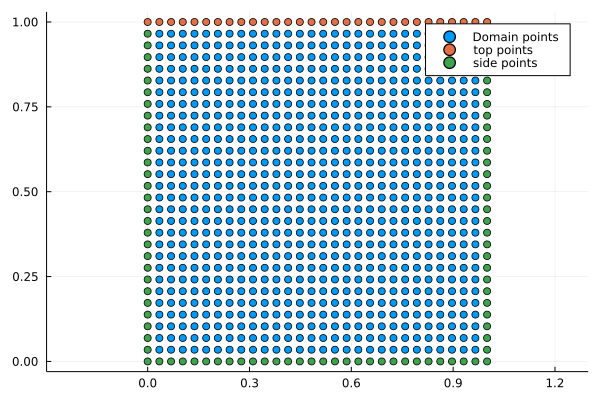

In [7]:
Plots.scatter(Internal_points[1,:],Internal_points[2,:],aspect_ratio=:equal,label = "Domain points")
Plots.scatter!(top_points[1,:],top_points[2,:],aspect_ratio=:equal,label ="top points")
Plots.scatter!(side_points[1,:],side_points[2,:],aspect_ratio=:equal,label ="side points")
#savefig("internal_domain_points.png")

In [5]:

Eval_points, _ =  generate_2D_equally_spaced_points(50)
N_eval = size(Eval_points)[2]

2304

Construct matrices

In [31]:
parameter = 10

# Stokes matrix
A_functions = construct_kernel_array(Φ_div,[λ1x,λ2x,λ3x,λ4x],[λ1y,λ2y,λ3y,λ4y])
A_functions= compile_kernel_array(A_functions)
A_tensor = crete_block_point_tensors([Internal_points,Internal_points,Boundary_points,Boundary_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
A = generate_block_matrices(A_functions,A_tensor,parameter)
A = flatten(A)

# transformation of coefficients to velocities and pressure
E_functions = construct_kernel_array(Φ_div,[λu,λv,λp],[λ1y,λ2y,λ3y,λ4y])
E_functions = compile_kernel_array(E_functions)
E_tensor = crete_block_point_tensors([Eval_points,Eval_points,Eval_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
E = generate_block_matrices(E_functions,E_tensor,parameter) 
E = flatten(E)

# Matrices for nonlinear terms 

U_functions = construct_kernel_array(Φ_div,[λu],[λ1y,λ2y,λ3y,λ4y])
#display(U_functions)
U_functions = compile_kernel_array(U_functions)
U_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
U = generate_block_matrices(U_functions,U_tensor,parameter) 
U = flatten(U)

V_functions = construct_kernel_array(Φ_div,[λv],[λ1y,λ2y,λ3y,λ4y])
V_functions = compile_kernel_array(V_functions)
V_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
V = generate_block_matrices(V_functions,V_tensor,parameter) 
V = flatten(V)

Ux_functions = construct_kernel_array(Φ_div,[λ∂₁u],[λ1y,λ2y,λ3y,λ4y])
Ux_functions = compile_kernel_array(Ux_functions)
Ux_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
Ux = generate_block_matrices(Ux_functions,Ux_tensor,parameter) 
Ux = flatten(Ux)

Uy_functions = construct_kernel_array(Φ_div,[λ∂₂u],[λ1y,λ2y,λ3y,λ4y])
Uy_functions = compile_kernel_array(Uy_functions)
Uy_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
Uy = generate_block_matrices(Uy_functions,Uy_tensor,parameter) 
Uy = flatten(Uy)


Vx_functions = construct_kernel_array(Φ_div,[λ∂₁v],[λ1y,λ2y,λ3y,λ4y])
Vx_functions = compile_kernel_array(Vx_functions)
Vx_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
Vx = generate_block_matrices(Vx_functions,Vx_tensor,parameter) 
Vx = flatten(Vx)

Vy_functions = construct_kernel_array(Φ_div,[λ∂₂v],[λ1y,λ2y,λ3y,λ4y])
Vy_functions = compile_kernel_array(Vy_functions)
Vy_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
Vy = generate_block_matrices(Vy_functions,Vy_tensor,parameter) 
Vy = flatten(Vy)


println(cond(A))


function g(t)
    res = zeros(N_b*2)
    res[1:N_top] .= min(t,8.0)
    return res
end

f = generate_vector_function([f₁,f₂],Internal_points)

g(1.2)

matrices = [A,U,Ux,Uy,V,Vx,Vy]
print("done")

1.642138659548546e12
done

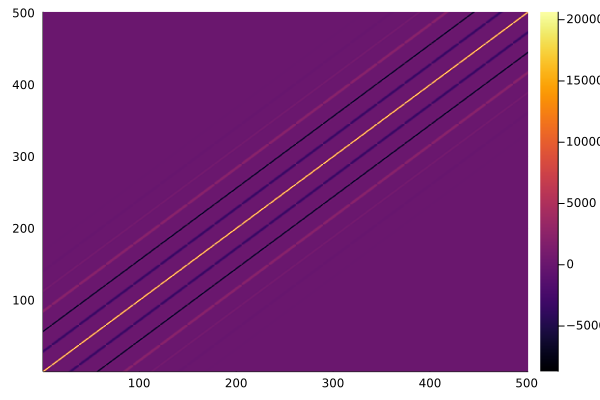

In [9]:
Plots.heatmap(A[1000:1500,1000:1500])

In [10]:
function assemble_matrix!(M,c,mat)
    A,U,Ux,Uy,V,Vx,Vy = mat
    N = size(A)[1]
    N_i = size(U)[1]
    N_b = N - N_i
    u = U*c
    v = V*c
    M[1:N_i,1:N] .= u .* Ux .+ v .* Uy
    M[1+N_i:2*N_i,1:N] .= u .* Vx .+ v .* Vy
    M[2*N_i:end,1:end] .= 0
    M .=  A .-M
    return M

end
function assemble_RHS!(RHS,c,mat)
    A,U,Ux,Uy,V,Vx,Vy = mat
    N = size(A)[1]
    N_i = size(U)[1]
    N_b = N - N_i
    u = U*c
    v = V*c
    RHS[1:N_i] .= (u .* Ux .+ v .* Uy)*c
    RHS[1+N_i:2*N_i] .= (u .* Vx .+ v .* Vy)*c
end

assemble_RHS! (generic function with 1 method)

Solve using Picard Linearization for Re = 50

In [37]:
RHS = zeros(2*N)
RHS[2*N_i+1:2*N_i+N_top] .= ones(N_top)

c = zeros(2*N)
c_old = zeros(2*N)
M = zeros((2*N,2*N))
N_iter = 1200
error_array = []
for i in 1:N_iter
    #assemble_RHS!(RHS,c,matrices)
    assemble_matrix!(M,c,matrices)
    c_old .= c
    c = M\RHS
    append!(error_array,[norm(c-c_old)])
end
#c = A\RHS
sol = E*c # calculate u,v and p at evaluation points 
#heatmap!(A)

6912-element Vector{Float64}:
 -0.00637796568108133
  0.00198315692459825
  0.000268865586377337
 -0.0028780812186754803
 -0.0023936692698763497
 -0.001585392748923336
 -0.0019447339699747094
 -0.0019479653066219581
 -0.0014699810452694635
 -0.0016396790108433458
 -0.002085376884888057
 -0.0018793433291211478
 -0.0017721937858353053
  ⋮
  0.019549053061666655
  0.032490389047381996
  0.04895005610433145
  0.06918949499186056
  0.09434117333432823
  0.1246764675399703
  0.1576086756458892
  0.19063872955351258
  0.22525205125134562
  0.2602857524340436
  0.27670314949392605
  0.23574292080274972

### Plot showing how fast Picard iteration converges 
It can be seen that the error does not fall below certain value, even though the condition number is only $10^{12}$. I would expect the error of the order $10^{-4}$ 


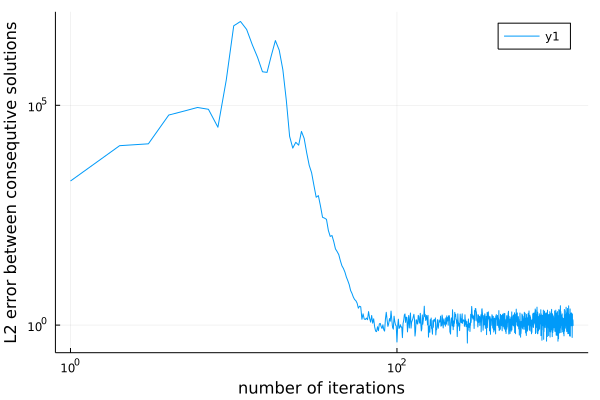

In [38]:
Plots.plot(1:N_iter,error_array,yscale = :log10,xscale = :log10,xlabel="number of iterations",
ylabel = "L2 error between consequtive solutions")
#error_array
#println(maximum(c))
#println(maximum(RHS))

In [39]:
maximum(sol)

0.811140504171664

0.0034668228831877435


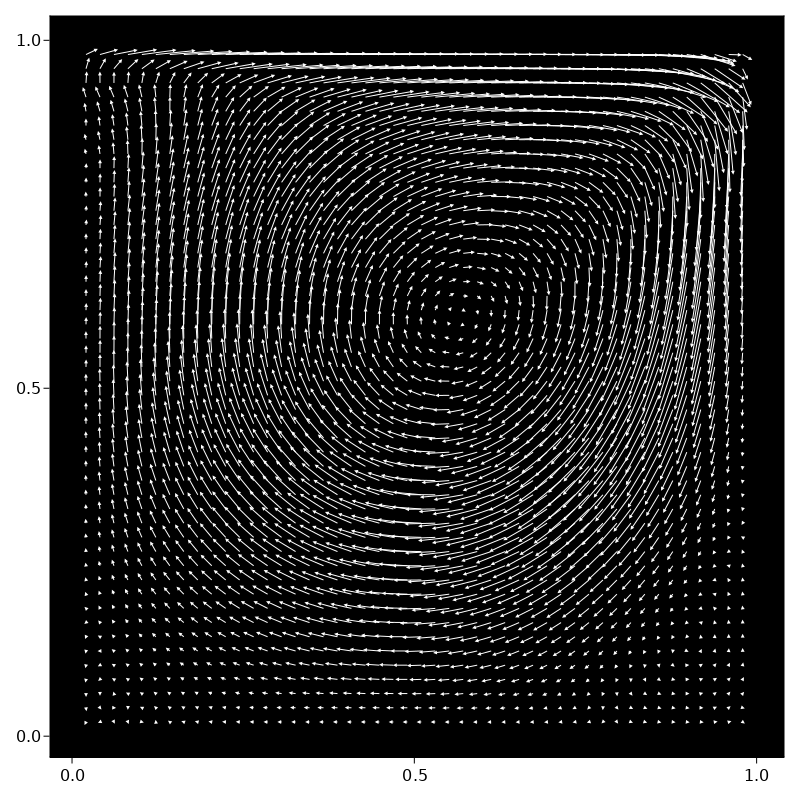

In [40]:

fig = Figure(resolution = (800, 800))
strength = sqrt.(sol[1:N_i] .^2 .+ sol[1+N_i:2*N_i] .^2)
println(minimum(strength))
Axis(fig[1, 1], backgroundcolor = "black")
arrows!(Eval_points[1,:], Eval_points[2,:], sol[1:N_eval], sol[1+N_eval:2*N_eval], arrowsize = 5,lengthscale = 0.15,
arrowcolor = :white, linecolor = :white)
fig

#### Lid driven cavity u velocity as a function of y comparison with literature for Re = 400

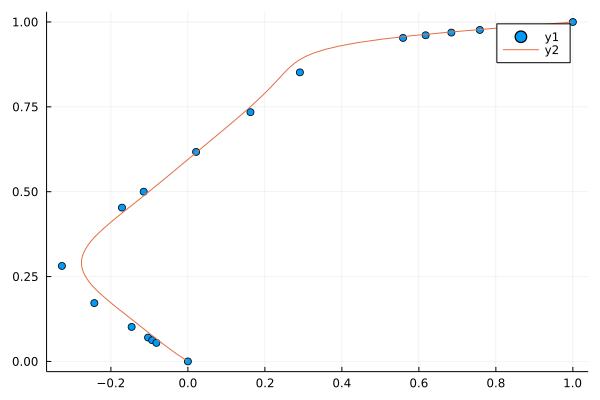

In [36]:
ref_u = vec([ 1.00000 0.75837 0.68439 0.61756 0.55892 0.29093 0.16256 0.02135 -0.11477 -0.17119 -0.32726 -0.24299 -0.14612 -0.10338 -0.09266 -0.08186 0.00000])
y =vec([1.00000 0.9766 0.9688 0.9609 0.9531 0.8516 0.7344 0.6172 0.5000 0.4531 0.2813 0.1719 0.1016 0.0703 0.0625 0.0547 0.0000])

Eval_points2 = hcat(0.5*ones(100),LinRange(0,1,100))'

E_tensor2 = crete_block_point_tensors([Eval_points2],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
E2 = generate_block_matrices(U_functions,E_tensor2,parameter) 
E2 = flatten(E2)
comparison = E2*c
Plots.scatter(ref_u,y)
Plots.plot!(comparison,Eval_points2[2,:])